Raw Image info: (224, 224, 3)
Raw Image datatype: uint8
Resized Image shape (numpy array): (32, 32)


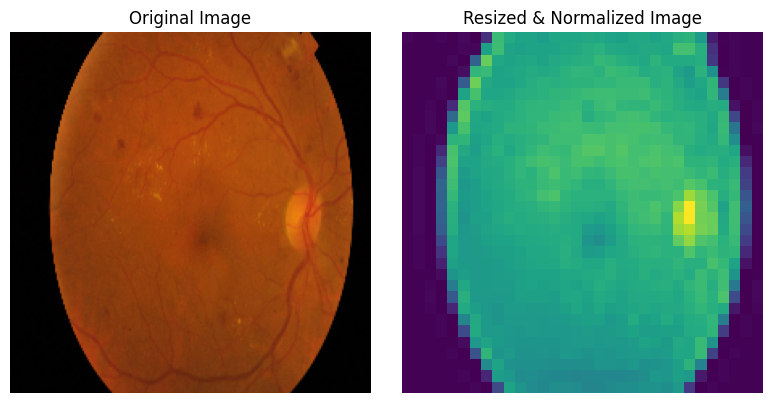

In [55]:
from qiskit import *
from qiskit.compiler import transpile, assemble
from qiskit.visualization import *
import skimage.color
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import math

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Constants
image_size = 256       # Original image width (you can change this based on your original image size)
image_crop_size = 32   # Width of each part of the image for processing

# Load the image from the filesystem
image_path = 'Desktop/Quantum Journal/Datasets/Retina dataset/Severe/c0a0828e01b4.png'
image_raw = np.array(Image.open(image_path))

print('Raw Image info:', image_raw.shape)
print('Raw Image datatype:', image_raw.dtype)

# Convert the RGB component of the image to a B&W image, as a numpy (float32) array
image = np.array(Image.open(image_path).convert('L'))  # Convert to grayscale
image_resized = Image.fromarray(image).resize((image_crop_size, image_crop_size), Image.LANCZOS)  # Resize with high-quality interpolation
image_normalized = np.array(image_resized) / 255.0  # Normalize to [0, 1]

print('Resized Image shape (numpy array):', image_normalized.shape)

# Display the original and processed images
plt.figure(figsize=(8, 4))

# Show the original image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image_raw, extent=[0, image_raw.shape[1], image_raw.shape[0], 0])
plt.axis('off')

# Show the resized and normalized image
plt.subplot(1, 2, 2)
plt.title('Resized & Normalized Image')
plt.imshow(image_normalized, extent=[0, image_normalized.shape[1], image_normalized.shape[0], 0], cmap='viridis')
plt.axis('off')

plt.tight_layout()
plt.show()


In [11]:
# # Path to your image folder
# input_folder = "Desktop/Quantum Journal/Datasets/Breast cancer dataset/benign"
# output_folder = "Desktop/Quantum Journal/Code/Preprocessed data/Breast cancer dataset/benign"
# os.makedirs(output_folder, exist_ok=True)



In [57]:
#we encode the intensities of image pixels as probability amplitudes of quantum states
#we use normalization for this
#we normalize the amplitudes to lie in the range (0,1)

# Convert the raw pixel values to probability amplitudes

def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms_32_rgb = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms_32_rgb)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)


#we now normalize image and get coefficients in both horizontal and vertical directions

# Horizontal: Original image
h_norm_image_32_rgb = amplitude_encode(image_normalized)
print("Horizontal image normalized coefficients",h_norm_image_32_rgb)


print()
print()

# Vertical: Transpose of Original image
v_norm_image_32_rgb = amplitude_encode(image_normalized.T)
print("vertical image normalized coefficients",v_norm_image_32_rgb)

print()
print("size of 1d array",h_norm_image_32_rgb.shape)
print("size of 1d array",v_norm_image_32_rgb.shape)

Horizontal image normalized coefficients [0.00083107 0.00041553 0.00041553 ... 0.00041553 0.00041553 0.00041553]


vertical image normalized coefficients [0.00083107 0.00041553 0.00041553 ... 0.00041553 0.00041553 0.00041553]

size of 1d array (1024,)
size of 1d array (1024,)


In [59]:
#we require N=log(32*32) qubits 
#N=10

data_q_32_rgb = 10
ancillary_q_32_rgb = 1
total_q_32_rgb = data_q_32_rgb + ancillary_q_32_rgb

# Initialize the amplitude permutation unitary
Amp_permutation_unitary_32_rgb = np.identity(2**total_q_32_rgb)
print(Amp_permutation_unitary_32_rgb)
Amp_permutation_unitary_32_rgb=np.roll(Amp_permutation_unitary_32_rgb,1,axis=1)
print()
print()
print()
print("shift Amplitude permutation matrix by 1 unit to the right column wise")
print()
print(Amp_permutation_unitary_32_rgb)
print()
print("we will later use this for while applying hadamard operation to image coefficient vectors")
print()
print(Amp_permutation_unitary_32_rgb.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]



shift Amplitude permutation matrix by 1 unit to the right column wise

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]]

we will later use this for while applying hadamard operation to image coefficient vectors

(2048, 2048)


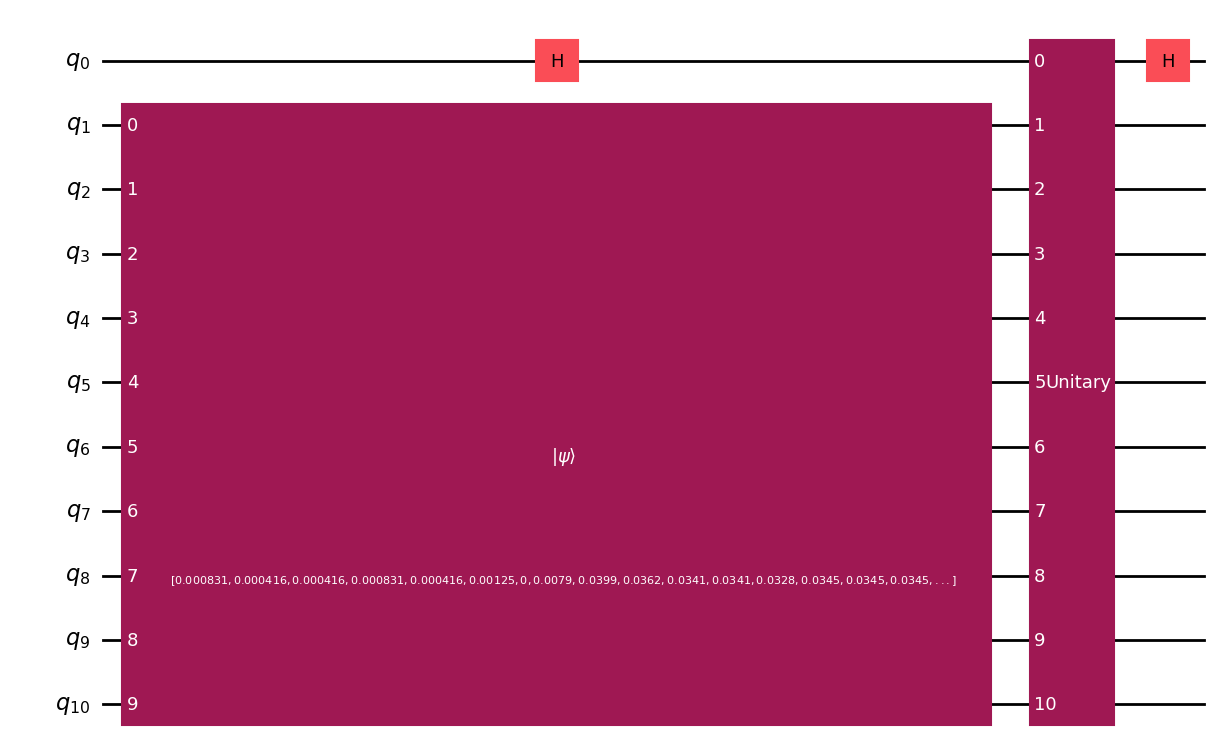

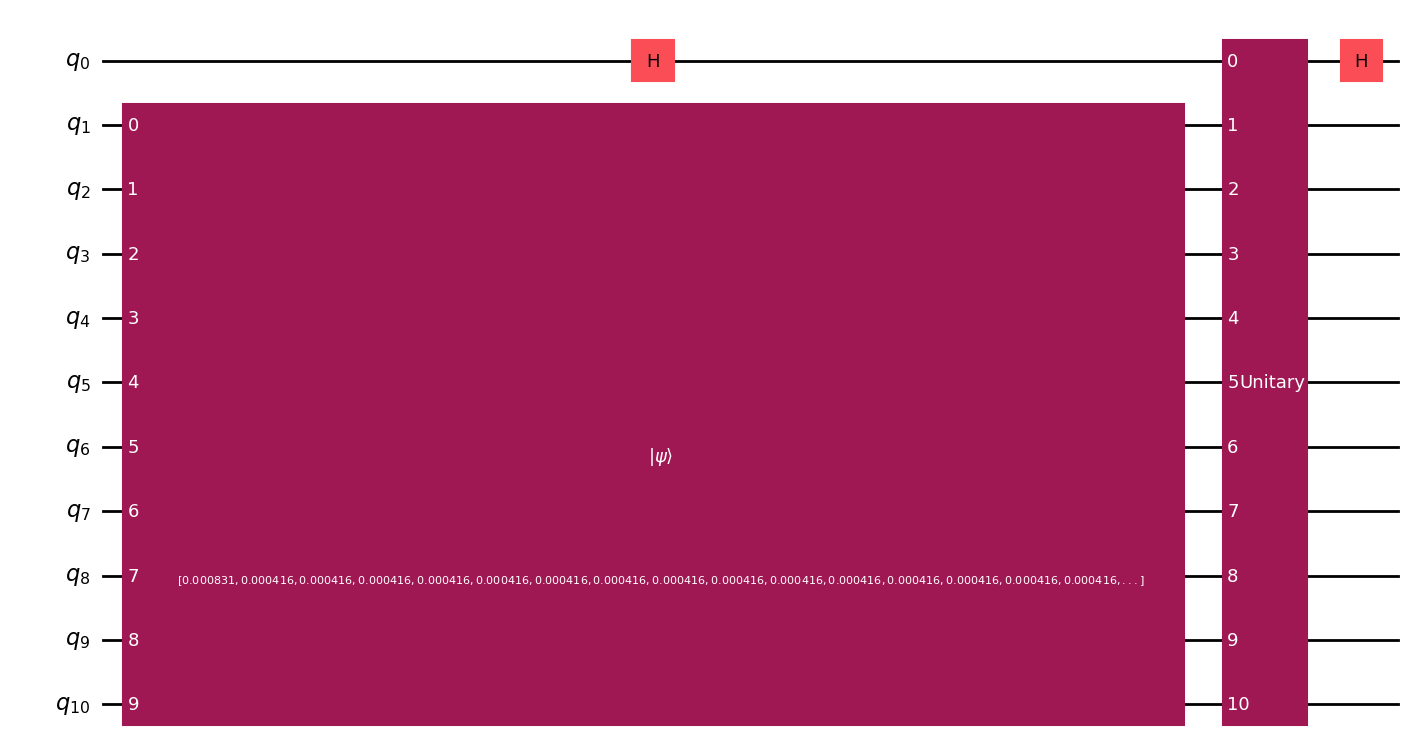

In [61]:
# Creating the circuit for horizontal scan

qc_h_32_rgb = QuantumCircuit(total_q_32_rgb)
qc_h_32_rgb.initialize(h_norm_image_32_rgb, range(1, total_q_32_rgb))
qc_h_32_rgb.h(0)
qc_h_32_rgb.unitary(Amp_permutation_unitary_32_rgb, range(total_q_32_rgb))
qc_h_32_rgb.h(0)

display(qc_h_32_rgb.draw('mpl', fold=-1))


# Create the circuit for vertical scan
qc_v_32_rgb = QuantumCircuit(total_q_32_rgb)
qc_v_32_rgb.initialize(v_norm_image_32_rgb, range(1, total_q_32_rgb))
qc_v_32_rgb.h(0)
qc_v_32_rgb.unitary(Amp_permutation_unitary_32_rgb, range(total_q_32_rgb))
qc_v_32_rgb.h(0)

display(qc_v_32_rgb.draw('mpl', fold=-1))

# Combine both circuits into a single list
circ_list_32_rgb = [qc_h_32_rgb, qc_v_32_rgb]


In [63]:
# Import necessary libraries
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import array_to_latex
import numpy as np

# Define the AerSimulator backend
backend = AerSimulator(method='statevector')
backend.set_options(
    max_parallel_threads=0,
    max_parallel_experiments=0,
    max_parallel_shots=1,
    statevector_parallel_threshold=16
)

# Apply save_statevector to each circuit in circ_list_32_rgb
for circuit in circ_list_32_rgb:
    circuit.save_statevector()  # Save the statevector for each circuit

# Generate the pass manager for optimization
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

# Transpile and run each circuit
compiled_circuits = [pm.run(circuit) for circuit in circ_list_32_rgb]

# Run the circuits on the simulator
results = backend.run(compiled_circuits, shots=1).result()

# Retrieve the statevectors
state_vector_h_32_rgb = results.get_statevector(compiled_circuits[0])
state_vector_v_32_rgb = results.get_statevector(compiled_circuits[1])

# Display the statevector sizes
print("Size of horizontal scan statevector:", len(state_vector_h_32_rgb))
print("Size of vertical scan statevector:", len(state_vector_v_32_rgb))

# Display the results as LaTeX
print('Horizontal scan statevector:')
display(array_to_latex(state_vector_h_32_rgb, max_size=128))
print('\nVertical scan statevector:')
display(array_to_latex(state_vector_v_32_rgb, max_size=128))



C:\Users\rezua\AppData\Local\Temp\ipykernel_14180\2228104758.py:35: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  print("Size of horizontal scan statevector:", len(state_vector_h_32_rgb))
C:\Users\rezua\AppData\Local\Temp\ipykernel_14180\2228104758.py:36: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  print("Size of vertical scan statevector:", len(state_vector

Size of horizontal scan statevector: 2048
Size of vertical scan statevector: 2048
Horizontal scan statevector:


<IPython.core.display.Latex object>


Vertical scan statevector:


<IPython.core.display.Latex object>

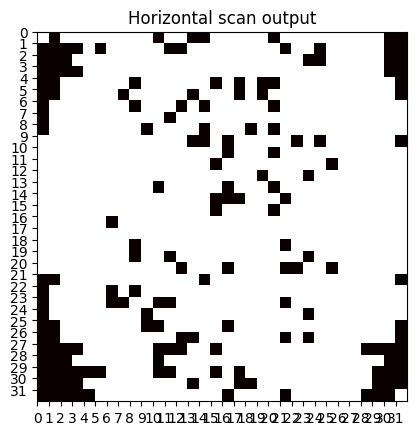

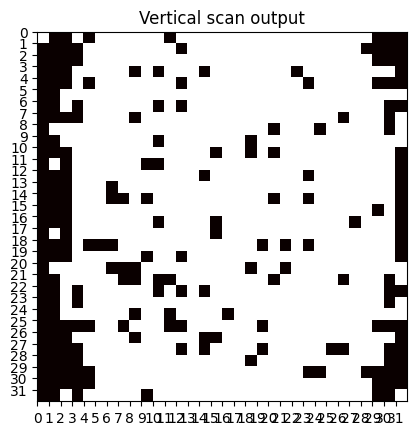

In [65]:
#  postprocessing for plotting the output (Classical)

# Defining a lambda function for thresholding to binary values
# returns true for specified Amplitude values else false
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
h_edge_scan_img_32_rgb = np.abs(np.array([1 if threshold(state_vector_h_32_rgb[2*(i)+1].real) else 0 for i in range(2**data_q_32_rgb)])).reshape(32, 32)
v_edge_scan_img_32_rgb= np.abs(np.array([1 if threshold(state_vector_v_32_rgb[2*(i)+1].real) else 0 for i in range(2**data_q_32_rgb)])).reshape(32, 32).T

# Plotting the Horizontal and vertical scans
plot_image(h_edge_scan_img_32_rgb, 'Horizontal scan output')
plot_image(v_edge_scan_img_32_rgb, 'Vertical scan output')

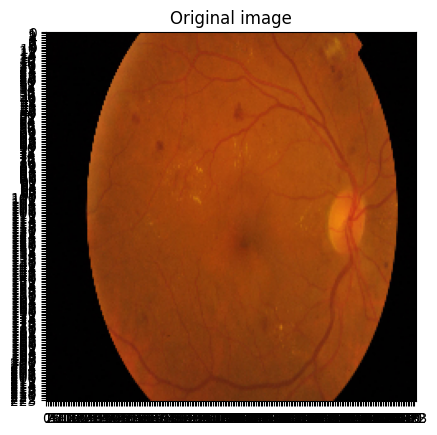

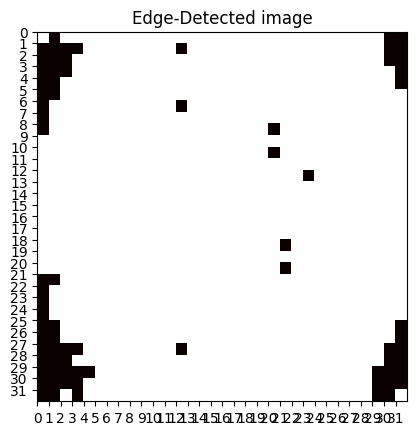

In [67]:
# Combining the horizontal and vertical component of the result by or operator
edge_scan_image_32_rgb = h_edge_scan_img_32_rgb | v_edge_scan_img_32_rgb

# Plotting the original and edge-detected images
plot_image(imggg_, 'Original image')
plot_image(edge_scan_image_32_rgb, 'Edge-Detected image')

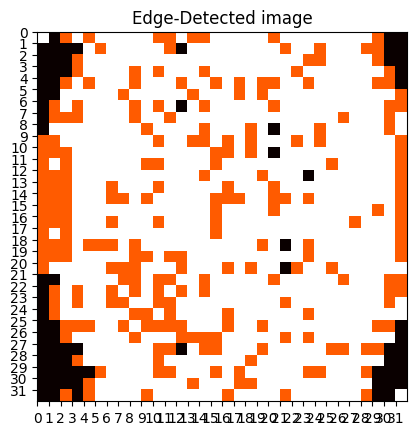

In [75]:
edge_scan_image_32_rgb_ =  h_edge_scan_img_32_rgb + v_edge_scan_img_32_rgb

plot_image(edge_scan_image_32_rgb_, 'Edge-Detected image')

In [77]:
edge_scan_image_32_rgb_

array([[2, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 2]])